Mostrar gráficamente la información de productos, tasas efectivas y valor final de un cliente.

Mostrar gráficamente el valor total del cliente que sea consultado.

In [1]:
import pandas
from tkinter import *
from pandastable import Table
import pyodbc
from getpass import getuser, getpass
import warnings
warnings.filterwarnings('ignore')

def get_dataframe_sql(params,params_query):
	"""
	Crea un dataframe desde tabla en la lz :
	- param: Diccionario con el DNS, Usuario y COntraseña de conexión
	- params_query: Diccionario la ruta del sql y los parametros internos del SQL
	"""		
	f = open(params_query["query"], "r")  # Abrir el archivo con el SQL
	sql = f.read()
	f.close()
	#Reemplazar prametros
	for word, replacement in params_query.items():
		sql = sql.replace(word, str(replacement))
	
	conn = pyodbc.connect("DSN="+params['DSN']+";UID="+params['user']+";PWD="+params['password'], autocommit=True)	
	datos = pandas.read_sql(sql,conn)
	conn.close()
	return datos

def consultar_datelle():
	"""
	Accción de clic en el boton Detalle
	"""
	inp = textBox.get(1.0, "end-1c")
	params_query = {
		'{documento}': inp,
		'query': "C:/Users/jdquinte/Documents/Prueba/jdquinte/Python parte 1/sql_3.3_detalle.sql",
	}
	datos = get_dataframe_sql(params,params_query)
	table.model.df = datos
	table.show()

def consultar_unico():
	"""
	Accción de clic en el boton Único
	"""
	inp = textBox.get(1.0, "end-1c")
	params_query = {
		'{documento}': inp,
		'query': "C:/Users/jdquinte/Documents/Prueba/jdquinte/Python parte 1/sql_3.3_unico.sql",
	}
	datos = get_dataframe_sql(params,params_query)
	table.model.df = datos
	table.show()

params = {
	'user': getuser(),
	'password': getpass(prompt="Contraseña "+getuser()+":"),
	'DSN':'IMPALA_PROD'
}

app = Tk()
app.title("Aplicación Clientes")
app.geometry("700x350")
mi_Frame = Frame(app)
mi_Frame.pack(side=TOP)
label = Label(mi_Frame, text='Documento:')
textBox=Text(mi_Frame, height=1, width=30)
boton = Button(mi_Frame, text="Detalle",command=consultar_datelle)
boton2 = Button(mi_Frame, text="Único",command=consultar_unico)
label.pack(side=LEFT)
textBox.pack(side=LEFT)
boton.pack(side=RIGHT)
boton2.pack(side=RIGHT)
frame = Frame(app)
frame.pack(side=BOTTOM)
table = Table(frame, showtoolbar=True, showstatusbar=True)
app.mainloop()

Cargar ambos conjuntos de datos en Python utilizando pandas.

Fusione ambos conjuntos de datos en función de las columnas relevantes.

In [121]:
import numpy as np

#Cargar ambos conjuntos de datos en Python utilizando pandas.
obligaciones = pandas.read_excel("Obligaciones_clientes.xlsx", sheet_name="Obligaciones_clientes")
tasas = pandas.read_excel("tasas_productos.xlsx", sheet_name="Tasas")

#Fusionar ambos conjuntos de datos en función de las columnas relevantes.
datos = pandas.merge(obligaciones,tasas,\
                    left_on=['cod_segm_tasa','cod_subsegm_tasa','cal_interna_tasa'],\
                    right_on=['cod_segmento','cod_subsegmento','calificacion_riesgos'],how="inner")

datos['fecha_desembolso'] = pandas.to_datetime(datos['fecha_desembolso'])

#Tomamos la tasa correspondiente de acuerdo  al id de producto
datos['tasa'] = np.where(datos['id_producto'].str[-20:] == 'operacion_especifica', datos['tasa_operacion_especifica'],
              np.where(datos['id_producto'].str[-13:] == 'Cartera Total', datos['tasa_cartera'],
              np.where(datos['id_producto'].str[-7:] == 'cartera', datos['tasa_cartera'],
              np.where(datos['id_producto'].str[-7:] == 'leasing', datos['tasa_leasing'],
              np.where(datos['id_producto'].str[-4:] == 'Sufi', datos['tasa_sufi'],
              np.where(datos['id_producto'].str[-9:] == 'factoring', datos['tasa_factoring'],
              np.where(datos['id_producto'].str[-11:] == 'Hipotecario', datos['tasa_hipotecario'],
                       datos['tasa_tarjeta']
                       )))))))

#Calculamos un producto genérico de acuerdo al id de producto
datos['producto'] = np.where(datos['id_producto'].str[-20:] == 'operacion_especifica', 'operacion_especifica',
              np.where(datos['id_producto'].str[-13:] == 'Cartera Total', 'Cartera',
              np.where(datos['id_producto'].str[-7:] == 'cartera', 'Cartera',
              np.where(datos['id_producto'].str[-7:] == 'leasing', 'leasing',
              np.where(datos['id_producto'].str[-4:] == 'Sufi', 'Sufi',
              np.where(datos['id_producto'].str[-9:] == 'factoring', 'factoring',
              np.where(datos['id_producto'].str[-11:] == 'Hipotecario', 'Hipotecario',
                       'Tarjeta de Credito'
                       )))))))

#Filramos las columnas relevantes 
datos = datos[['radicado', 'num_documento', 'cod_segm_tasa', 'cod_subsegm_tasa', 'cal_interna_tasa',
'id_producto', 'tipo_id_producto', 'producto', 'valor_inicial', 'fecha_desembolso', 'plazo',
'cod_periodicidad', 'periodicidad', 'saldo_deuda', 'modalidad', 'tipo_plazo', 'segmento', 
'calificacion_riesgos','tasa']]

#Valores faltantes por productos
datos.plazo.isnull().groupby([datos['producto']]).sum().astype(int).reset_index(name='count')

producto  count
0               Cartera      6
1           Hipotecario      0
2                  Sufi      0
3    Tarjeta de Credito      0
4             factoring      0
5               leasing      0
6  operacion_especifica      0

Solo para el producto Cartera tenemos datos nulos

Análisis exploratorio

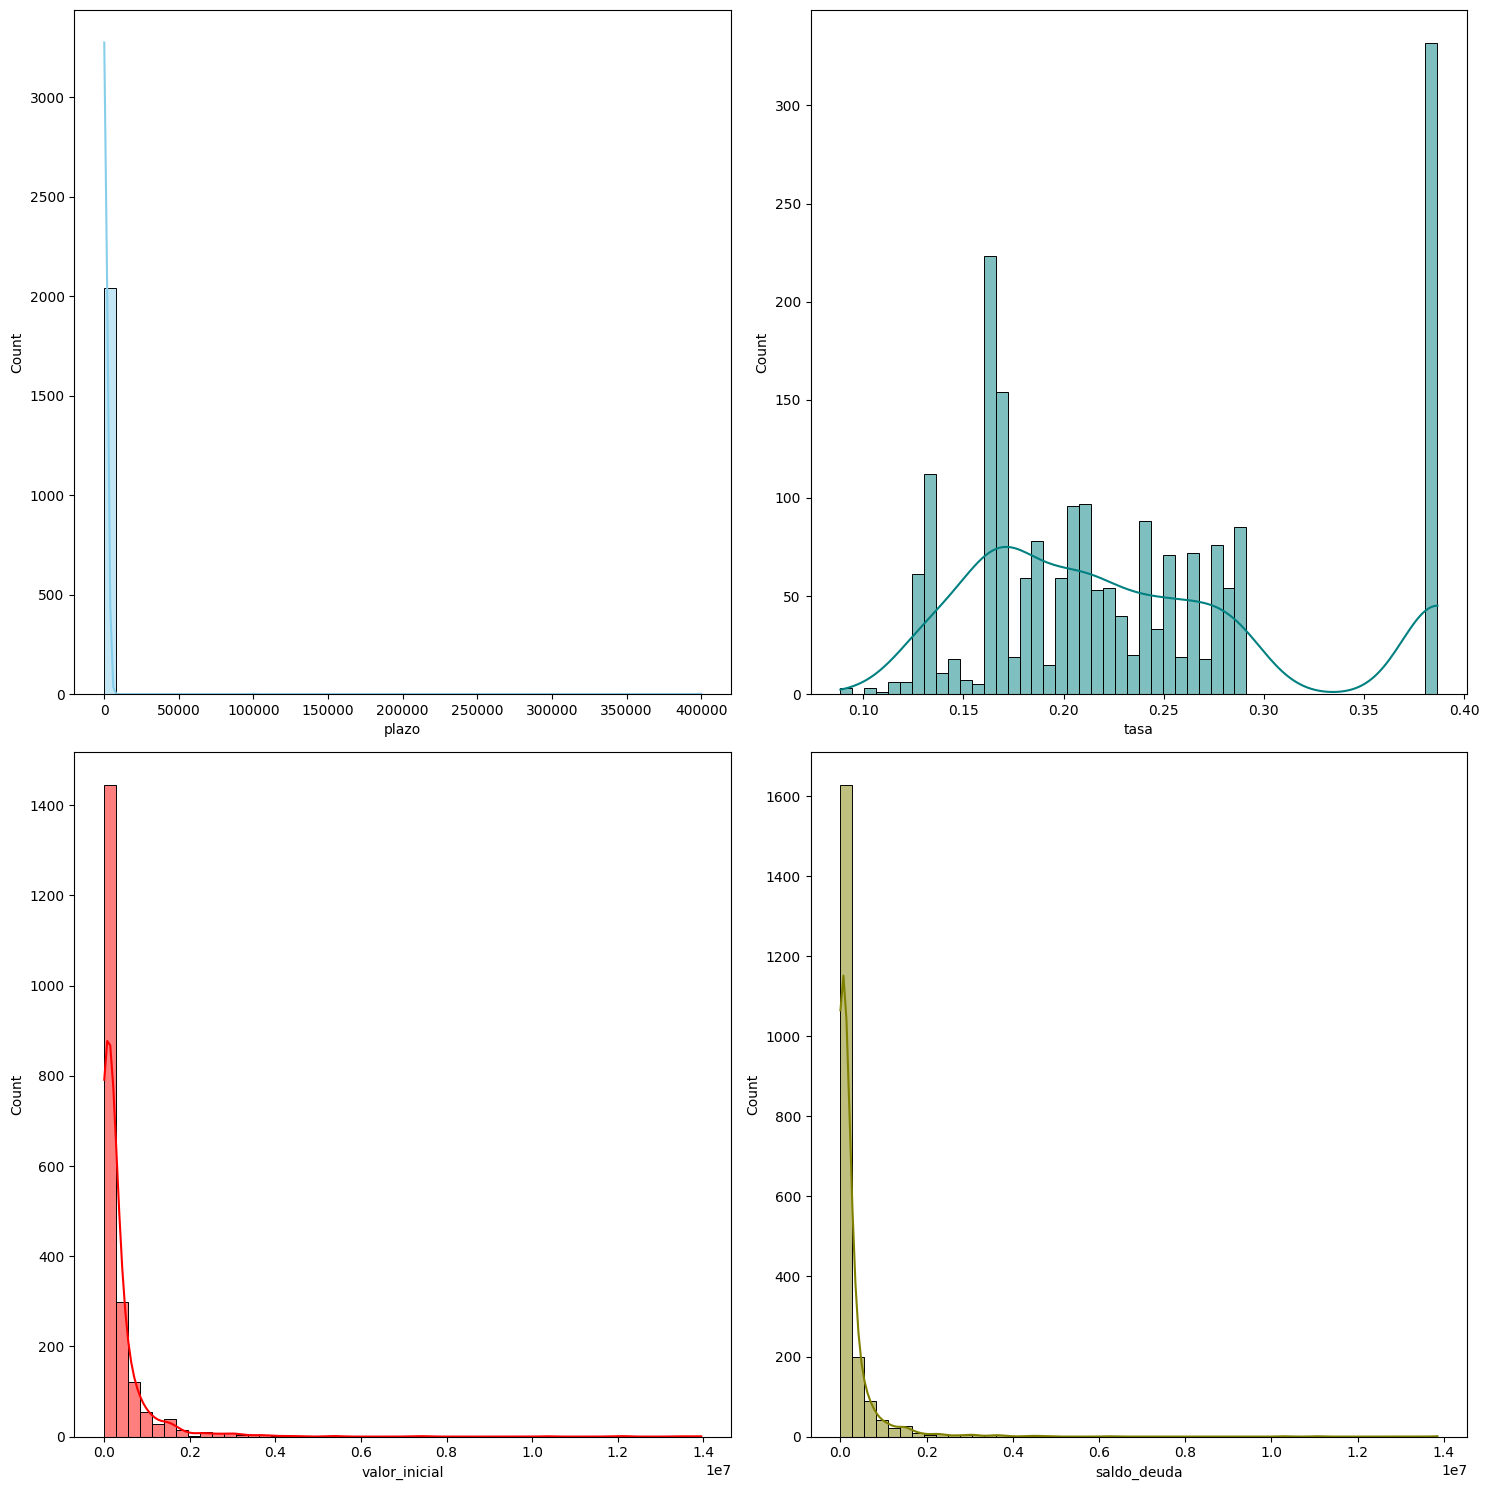

c:\Users\jdquinte\Documents\Prueba\.venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\jdquinte\AppData\Local\Temp\ipykernel_9336\793184783.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


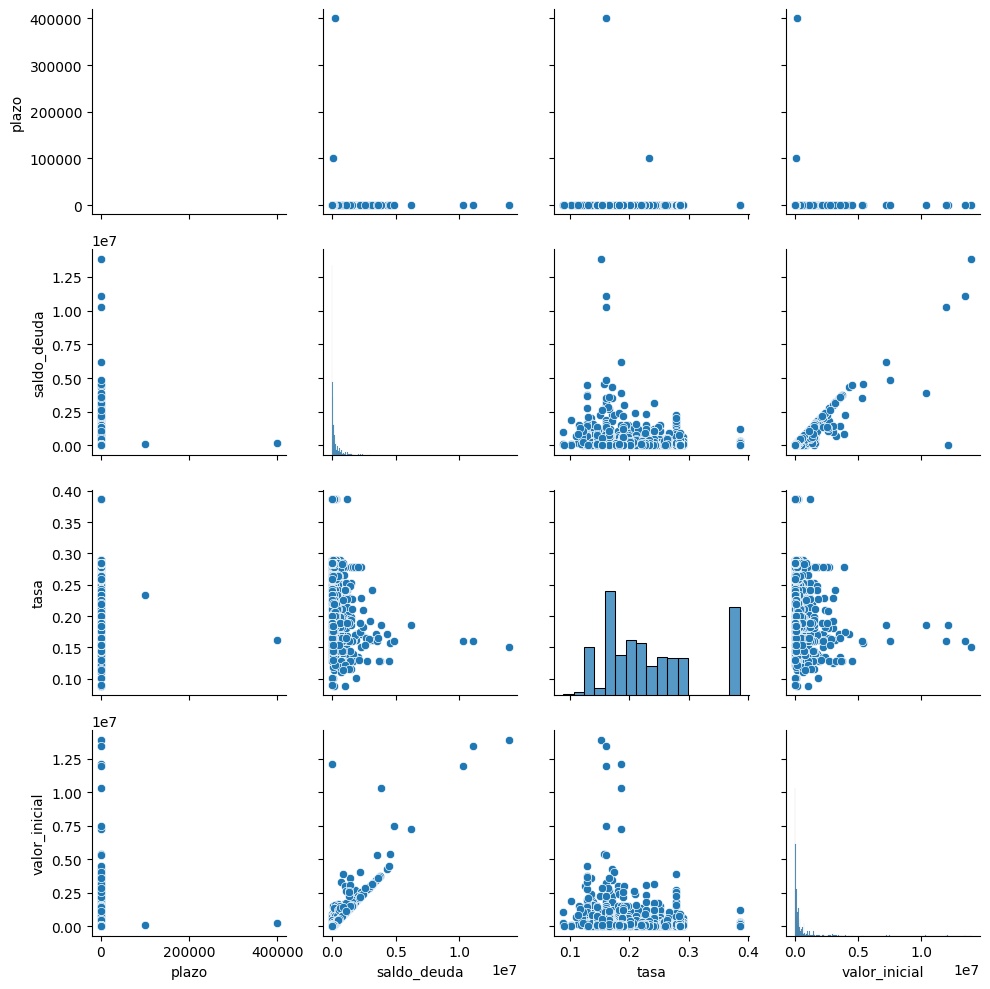

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.histplot(data=datos, bins = 50, x="plazo", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=datos, bins = 50, x="saldo_deuda", kde=True, color="olive", ax=axs[1, 1])
sns.histplot(data=datos, bins = 50, x="tasa", kde=True, color="teal", ax=axs[0, 1])
sns.histplot(data=datos, bins = 50, x="valor_inicial", kde=True, color="red", ax=axs[1, 0])

## Mostramos Gráfica
plt.tight_layout()
plt.show()

sns.pairplot(datos[["plazo","saldo_deuda","tasa","valor_inicial"]])
## Mostramos Gráfica
plt.tight_layout()
plt.show()

Las variables "saldo_deuda" y "valor_inicial" tienen una gran dispersión. Los valores máximos de "plazo" 100000 y 400000, son outliers. Las variables "plazo","saldo_deuda" y "valor_inicial" tienen valores máximos muy extremos.

Para poner visualizar mejor las variables se filtraron los datos para eliminar dichos valores extremos. Para el filtrado se utilizó el rango intercuartílico, pero en lugar de utilizar el primer y tercer cuartil, se utiló el primer y noveno decil

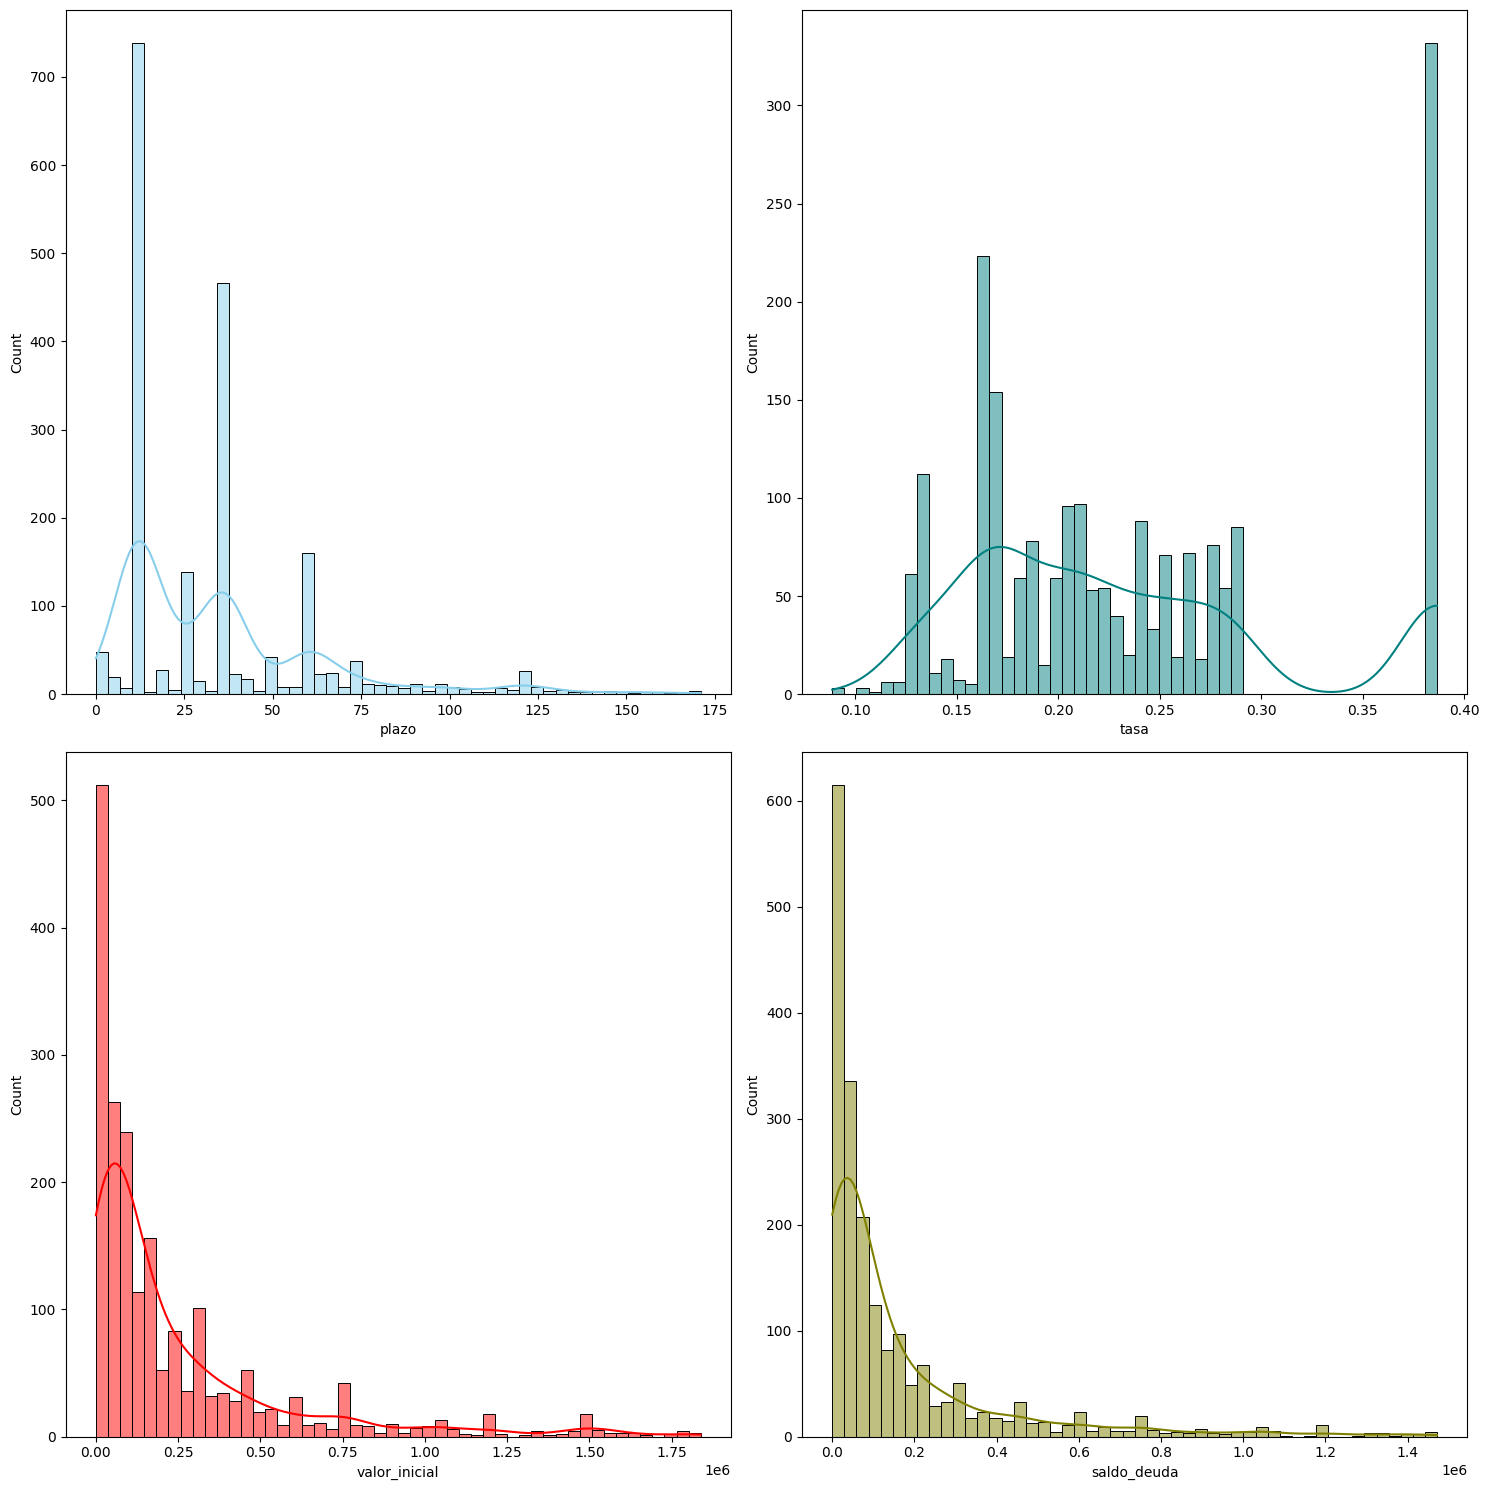

c:\Users\jdquinte\Documents\Prueba\.venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\jdquinte\AppData\Local\Temp\ipykernel_18836\155434136.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


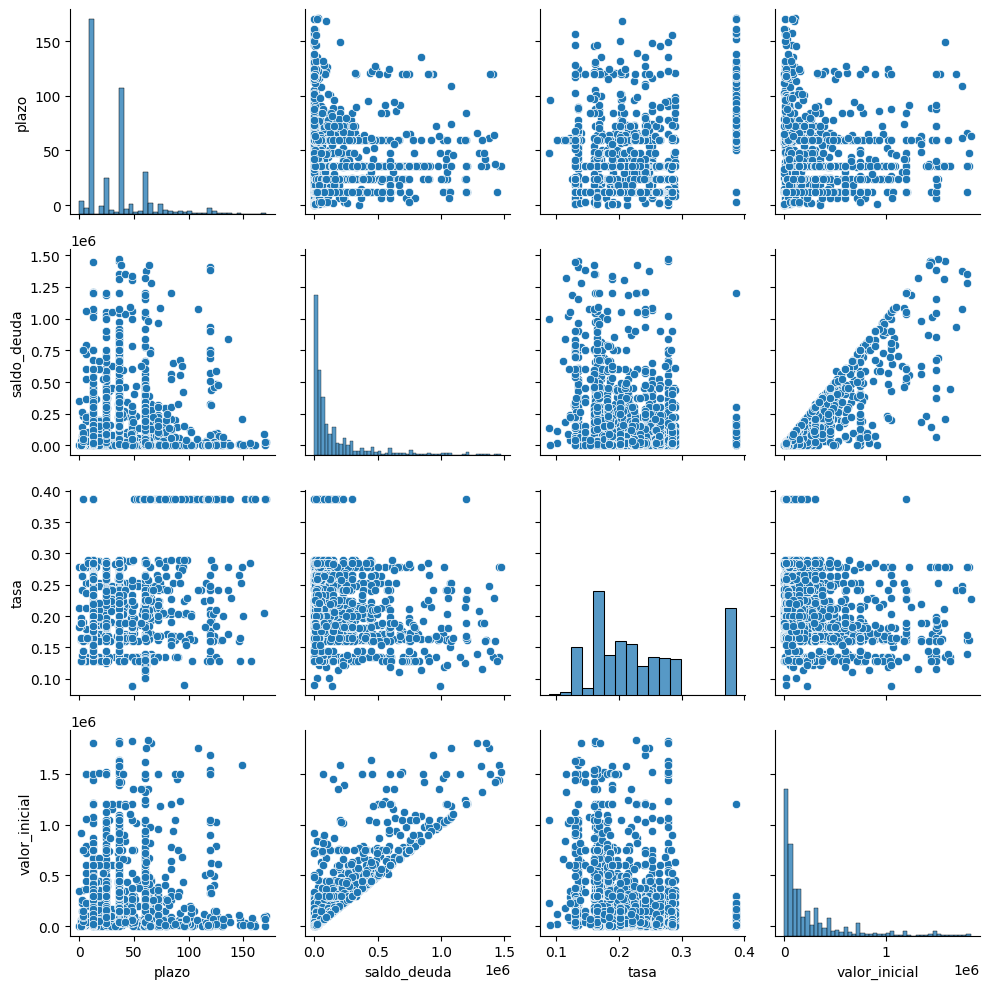

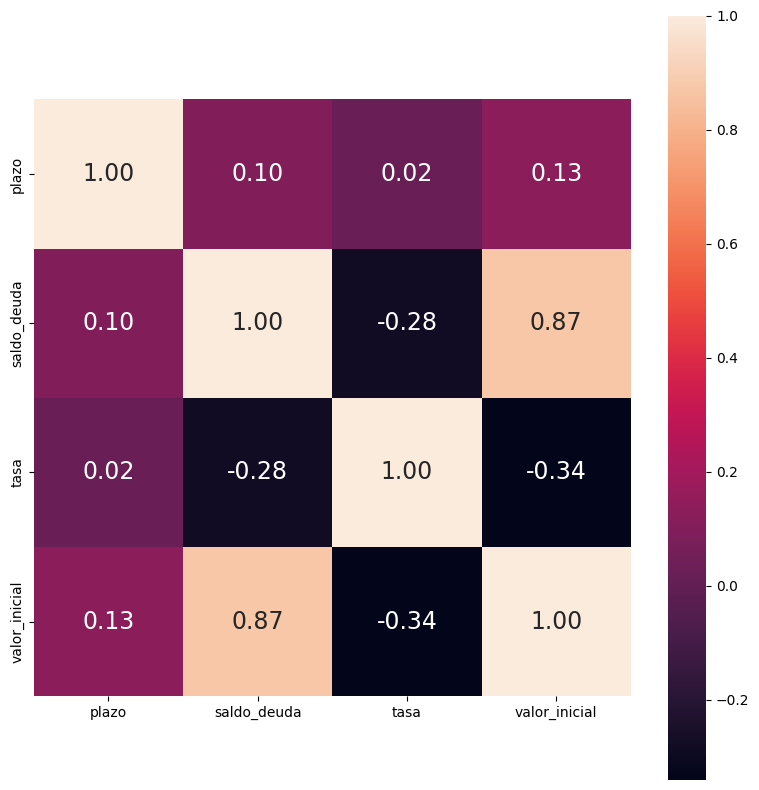

In [8]:

datos_aux = datos[["plazo","saldo_deuda","tasa","valor_inicial"]].copy()
minimo = datos_aux.quantile(0.1)
maximo = datos_aux.quantile(0.9)

IQR = maximo - minimo

datos_aux = datos_aux[~((datos_aux < (minimo - 1.5 * IQR)) | (datos_aux > (maximo + 1.5 * IQR)))]

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.histplot(data=datos_aux, bins = 50, x="plazo", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=datos_aux, bins = 50, x="saldo_deuda", kde=True, color="olive", ax=axs[1, 1])
sns.histplot(data=datos_aux, bins = 50, x="tasa", kde=True, color="teal", ax=axs[0, 1])
sns.histplot(data=datos_aux, bins = 50, x="valor_inicial", kde=True, color="red", ax=axs[1, 0])

plt.tight_layout()
plt.show()

sns.pairplot(datos_aux)

plt.tight_layout()
plt.show()


corr = datos_aux.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True, square = True, annot=True, fmt= '.2f',annot_kws={'size': 17})## numero de digitos y tamano de los numeros

## Mostramos Gráfica
plt.tight_layout()
plt.show()

En las gráficas anteriores podemos observar que las variables saldo deuda y valor inicial la mayoría de los valores se concentran en el lado izquierdo con una alta disección en el lado derecho y que tienen una correlación positiva. Las variables tasa y plazo tienen unas modas muy marcadas en los datos.

función para calcular el monto total de la deuda para cada segmento de 
cliente

In [122]:
def deuda_segmento ():
    deuda = datos.saldo_deuda.groupby([datos['segmento']]).sum()\
        .astype(int).reset_index(name='deuda_segmento')
    return deuda

deuda_segmento()

segmento  deuda_segmento
0                Empresarial       149453277
1  NEGOCIOS E INDEPENDIENTES         3417052
2                       PYME       351420882

Graficamos las variables saldo_deuda y tasa segmentado por segmento para determinar más o menos como pueden están las agrupaciones

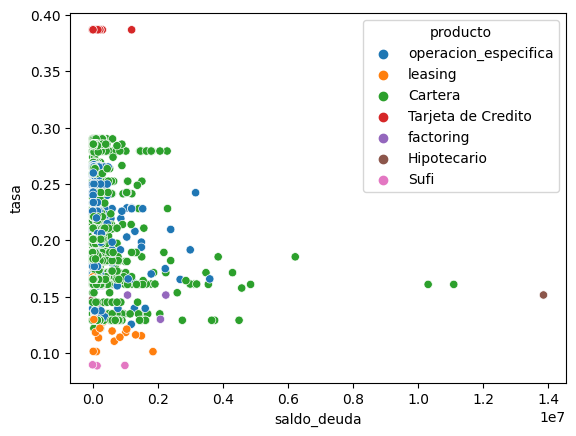

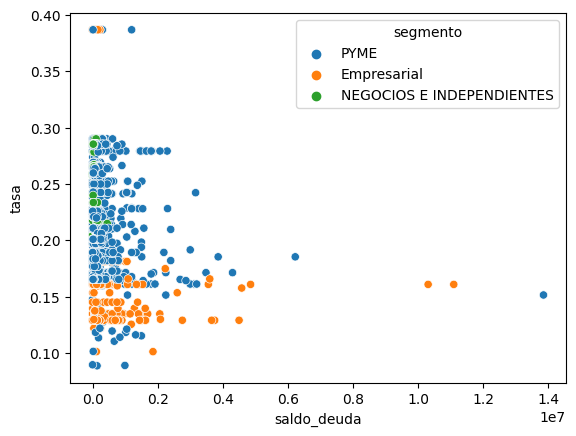

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x = datos["saldo_deuda"], y = datos["tasa"], hue = datos["segmento"])
plt.show()

K-means

Debemos convertir las tasas de los productos en columnas y sumar la totalidad de la deuda del cliente

In [123]:
import numpy as np
X = datos[["tasa","saldo_deuda","producto","segmento","num_documento"]].copy()
X = pandas.pivot_table(X, index=['num_documento','segmento'], \
                       columns=['producto'], values=['tasa','saldo_deuda'],aggfunc={'tasa':np.max, 'saldo_deuda':np.sum})

X.reset_index(inplace=True)
X.columns = X.columns.map('_'.join)
X.fillna(0,inplace=True)
X["saldo_deuda"] = X["saldo_deuda_Cartera"] + X["saldo_deuda_Hipotecario"]\
+ X["saldo_deuda_Sufi"] + X["saldo_deuda_Tarjeta de Credito"] + X["saldo_deuda_factoring"]\
+ X["saldo_deuda_leasing"] + X["saldo_deuda_operacion_especifica"]

X = X[['num_documento_','segmento_','saldo_deuda','tasa_Cartera','tasa_Hipotecario','tasa_Sufi','tasa_Tarjeta de Credito','tasa_factoring','tasa_leasing','tasa_operacion_especifica']]

X

num_documento_                  segmento_   saldo_deuda  tasa_Cartera  \
0           3907738  NEGOCIOS E INDEPENDIENTES  2.193961e+05      0.259170   
1           4234923                       PYME  4.486131e+05      0.220851   
2           4894508                       PYME  1.722517e+04      0.000000   
3           4935132                       PYME  8.157600e+05      0.204489   
4           7061608                       PYME  6.605438e+05      0.210699   
..              ...                        ...           ...           ...   
298      1339938146                       PYME  1.663500e+05      0.000000   
299      1342616595                       PYME  2.505687e+05      0.285235   
300      1344463827                       PYME  5.475000e+05      0.285235   
301      1346212202                       PYME  6.441435e+05      0.285235   
302      1353932845                       PYME  2.156044e+06      0.289897   

     tasa_Hipotecario  tasa_Sufi  tasa_Tarjeta de Credito  tasa_factoring  \
0                 0.0        0.0                   0.3867             0.0   
1                 0.0        0.0                   0.3867             0.0   
2                 0.0        0.0                   0.0000             0.0   
3                 0.0        0.0                   0.3867             0.0   
4                 0.0        0.0                   0.3867             0.0   
..                ...        ...                      ...             ...   
298               0.0        0.0                   0.3867             0.0   
299               0.0        0.0                   0.3867             0.0   
300               0.0        0.0                   0.3867             0.0   
301               0.0        0.0                   0.3867             0.0   
302               0.0        0.0                   0.3867             0.0   

     tasa_leasing  tasa_operacion_especifica  
0             0.0                   0.242689  
1             0.0                   0.225740  
2             0.0                   0.233440  
3             0.0                   0.214843  
4             0.0                   0.000000  
..            ...                        ...  
298           0.0                   0.225740  
299           0.0                   0.264941  
300           0.0                   0.264941  
301           0.0                   0.000000  
302           0.0                   0.000000  

[303 rows x 10 columns]

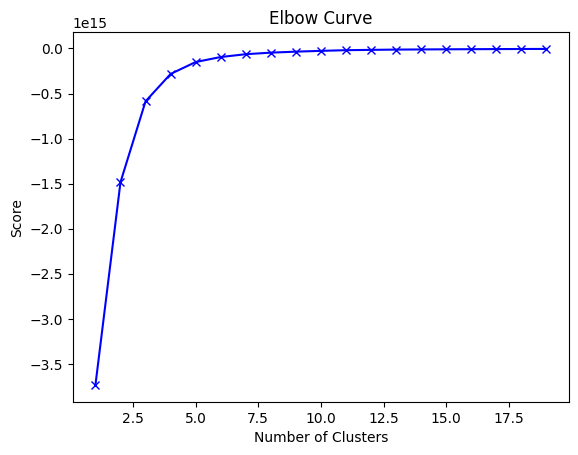

In [124]:
from sklearn.cluster import KMeans

X1 = X[['saldo_deuda','tasa_Cartera','tasa_Hipotecario','tasa_Sufi','tasa_Tarjeta de Credito','tasa_factoring','tasa_leasing','tasa_operacion_especifica']]
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X1).score(X1) for i in range(len(kmeans))]
plt.plot(Nc,score,'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Podemos observar que el "Elbow" es el número 5 que es óptimo para este caso. Ahora podemos ejecutar un K-Means usando como n_clusters el número 5.

In [125]:
kmeanModel = KMeans(n_clusters=5)
kmeanModel.fit(X1)
centroids = kmeanModel.cluster_centers_
labels = kmeanModel.predict(X1)
X["cluster"] = labels
X

num_documento_                  segmento_   saldo_deuda  tasa_Cartera  \
0           3907738  NEGOCIOS E INDEPENDIENTES  2.193961e+05      0.259170   
1           4234923                       PYME  4.486131e+05      0.220851   
2           4894508                       PYME  1.722517e+04      0.000000   
3           4935132                       PYME  8.157600e+05      0.204489   
4           7061608                       PYME  6.605438e+05      0.210699   
..              ...                        ...           ...           ...   
298      1339938146                       PYME  1.663500e+05      0.000000   
299      1342616595                       PYME  2.505687e+05      0.285235   
300      1344463827                       PYME  5.475000e+05      0.285235   
301      1346212202                       PYME  6.441435e+05      0.285235   
302      1353932845                       PYME  2.156044e+06      0.289897   

     tasa_Hipotecario  tasa_Sufi  tasa_Tarjeta de Credito  tasa_factoring  \
0                 0.0        0.0                   0.3867             0.0   
1                 0.0        0.0                   0.3867             0.0   
2                 0.0        0.0                   0.0000             0.0   
3                 0.0        0.0                   0.3867             0.0   
4                 0.0        0.0                   0.3867             0.0   
..                ...        ...                      ...             ...   
298               0.0        0.0                   0.3867             0.0   
299               0.0        0.0                   0.3867             0.0   
300               0.0        0.0                   0.3867             0.0   
301               0.0        0.0                   0.3867             0.0   
302               0.0        0.0                   0.3867             0.0   

     tasa_leasing  tasa_operacion_especifica  cluster  
0             0.0                   0.242689        0  
1             0.0                   0.225740        0  
2             0.0                   0.233440        0  
3             0.0                   0.214843        0  
4             0.0                   0.000000        0  
..            ...                        ...      ...  
298           0.0                   0.225740        0  
299           0.0                   0.264941        0  
300           0.0                   0.264941        0  
301           0.0                   0.000000        0  
302           0.0                   0.000000        4  

[303 rows x 11 columns]

In [60]:
df = X.groupby(['segmento_','cluster'],as_index=False, sort=True)\
    .agg(conteo = ("saldo_deuda","count"))

df

segmento_  cluster  conteo
0                Empresarial        0       4
1                Empresarial        1      10
2                Empresarial        2       1
3                Empresarial        3       2
4                Empresarial        4       1
5  NEGOCIOS E INDEPENDIENTES        0      22
6                       PYME        0     213
7                       PYME        1       6
8                       PYME        3      39
9                       PYME        4       5

Según el clúster asignado a cada cliente vemos que en el segmento NEGOCIOS E INDEPENDIENTES quedaron todos en el mismo clsuter "0", en PYME la gran mayoría quedo también en "0" y Empresarial en la gran mayoría quedo en "1". Podemos concluir que los segmentos NEGOCIOS E INDEPENDIENTES y PYME tiene tasas y deuda muy similares entres sus clientes y que probablemente en los segmentos Empresarial y PYME tengamos clientes mal segmentados.

Modelo de regresión

In [126]:
data_seleccion = datos[['producto','calificacion_riesgos', 'segmento','cod_periodicidad',
                'valor_inicial', 'plazo','cod_periodicidad', 'saldo_deuda', 'tasa']].copy()

data_seleccion = data_seleccion.dropna()

minimo = data_seleccion[['valor_inicial', 'plazo','cod_periodicidad', 'saldo_deuda', 'tasa']].quantile(0.1)
maximo = data_seleccion[['valor_inicial', 'plazo','cod_periodicidad', 'saldo_deuda', 'tasa']].quantile(0.9)
IQR = maximo - minimo

## tratamiento de ouliers
#clean_select = data_seleccion[~ \
#    ((data_seleccion[['valor_inicial', 'plazo','cod_periodicidad', 'saldo_deuda', 'tasa']] < (minimo - 1.5 * IQR))
#    | (data_seleccion[['valor_inicial', 'plazo','cod_periodicidad', 'saldo_deuda', 'tasa']] > (maximo + 1.5 * IQR))).any(axis=1)].copy()

clean_select = data_seleccion

Transformamos las variables categorías

In [127]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
clean_select.producto = le.fit_transform(clean_select.producto)
clean_select.calificacion_riesgos = le.fit_transform(clean_select.calificacion_riesgos)
clean_select.segmento = le.fit_transform(clean_select.segmento)

clean_select

producto  calificacion_riesgos  segmento  cod_periodicidad  \
0            6                    12         2                 1   
1            5                    12         2                 1   
2            0                    12         2                 1   
3            0                    12         2                 1   
4            6                    12         2                 1   
...        ...                   ...       ...               ...   
2043         0                     9         2                 1   
2044         0                     9         2                 1   
2045         0                     9         2                 1   
2046         3                     9         2                 1   
2047         6                     9         2                 1   

      valor_inicial  plazo  cod_periodicidad   saldo_deuda      tasa  
0      1.050000e+06   60.0                 1  1.050000e+06  0.202839  
1      7.528858e+04   60.0                 1  7.528858e+04  0.134434  
2      1.909350e+05   48.0                 1  1.159688e+05  0.190215  
3      3.305078e+05   64.0                 1  1.403725e+05  0.190215  
4      5.250000e+04   36.0                 1  2.333179e+04  0.202839  
...             ...    ...               ...           ...       ...  
2043   7.500000e+03   12.0                 1  7.500000e+03  0.183414  
2044   1.500000e+04   12.0                 1  1.500000e+04  0.183414  
2045   9.000000e+04   24.0                 1  9.000000e+04  0.183414  
2046   1.500000e+04   12.0                 1  1.500000e+04  0.386700  
2047   2.250000e+04   12.0                 1  2.250000e+04  0.259687  

[2042 rows x 9 columns]

In [112]:
# Separar datos en varialbes predictivas (x) y variable respuesta (y)
y = clean_select["saldo_deuda"]
x = clean_select.drop(["saldo_deuda"], axis=1)

In [113]:
# Separar los datos en entrenamiento y validacion
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [116]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 

reg_tree = DecisionTreeRegressor(random_state = 123)
reg_tree.fit(X_train, y_train)

y_train_pred = reg_tree.predict(X_train)

y_trest_pred = reg_tree.predict(X_test)

# Calculation of Mean Squared Error (RMSE)
print(np.sqrt(mean_squared_error(y_train,y_train_pred)))
# Calculation of Mean Squared Error (MAE)
print(mean_absolute_error(y_train,y_train_pred))

16045.835024986021
2104.2429300888


Tanto el RMSE y MAE con los datos de entrenamiento nos da un buen ajuste

In [118]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg_tree, x, y, cv=5)
print(scores)
scores.mean()

[ 0.45568694  0.92443288  0.75950722 -1.44956437  0.27820341]


0.1936532161765074

Observamos que los resultados no son buenos, muy cercanos al 100%, para cada uno de los 5 folds que hemos solicitado. De esta manera podemos concluir, considerando la validación cruzada que realizamos, se ha demostrado que el modelo no es bueno, puede ser a los datos atípicos que hay en los datos o que las variables seleccionas para entrenar el modelo no son los ideales.